In [8]:
import sys, argparse, os, copy, itertools, glob, datetime
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_fscore_support
from sklearn.datasets import load_svmlight_file
from collections import OrderedDict
from tqdm import tqdm
import pickle
import json
import torch.nn.functional as F
from sklearn.model_selection import KFold
import math 

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import time
import torch.nn as nn

from sklearn.linear_model import LogisticRegression, SGDClassifier
from collections import defaultdict

from openslide import open_slide, ImageSlide
import matplotlib.pyplot as plt
from skimage import exposure, io, img_as_ubyte, transform
import cv2

torch.manual_seed(0)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [9]:
# note that put the label (integer values) in same order as prompt order in GECKO/data_curation/prompts/../patch_prompts.json for corresponding datasets
# i.e if order of prompts in patch_prompts.json is first LUAD and then LUSC, then give 0 as a label for LUAD and 1 for LUSC.

name_to_label_dict = {}

# luad_vs_lusc 
name_to_label_dict['lung adenocarcinoma'] = 0
name_to_label_dict['lung squamous cell carcinoma'] = 1


# others_vs_ebv, others_vs_ebvnmsi, others_vs_msi
name_to_label_dict['others'] = 0
name_to_label_dict['EBV'] = 1
name_to_label_dict['EBVnMSI'] = 1
name_to_label_dict['MSI'] = 1


# her2 pos_vs_neg_equivocal
name_to_label_dict['Positive'] = 0
name_to_label_dict['Negative'] = 1
name_to_label_dict['Equivocal'] = 2

# Extract slide-level features

In [10]:
class GeckoDataset(Dataset):
    def __init__(self, features_deep_path, features_path, dataset_dict_path, split_path, cross_val_fold, test=False):

        with open(dataset_dict_path, 'rb') as f:
            self.dataset_dict = pickle.load(f)

        empty_keys_list = []
        for i in self.dataset_dict:
            if self.dataset_dict[i][1]-self.dataset_dict[i][0] == 0:
                empty_keys_list.append(i)
            
        print('empty_keys_list: ', empty_keys_list)

        for i in empty_keys_list:
            del self.dataset_dict[i]

        self.test = test

        self.features_deep_array = np.array(torch.load(features_deep_path).cpu().detach())
        print(self.features_deep_array.shape)
        
        self.features_array = pd.read_csv(features_path)
        self.features_array = self.features_array.set_index('Unnamed: 0')

        self.features_prompts = np.array(list(self.features_array.columns))

        print(self.features_array.shape)
        
        self.feats_size = self.features_array.shape[1]
        self.feats_size_deep = self.features_deep_array.shape[1]

        self.bags_path = list(self.dataset_dict.keys())

        # from ConcepPath paper
        train_path = []
        test_path = []

        fold_split = np.array(pd.read_csv(split_path + '/fold' + str(cross_val_fold) + '.csv').iloc[:,1:])

        for i in self.bags_path:
            for j in fold_split:
                if i in j[0]:
                    if j[-1] == 'train':
                        train_path.append(i)
                        self.dataset_dict[i].append(name_to_label_dict[j[1]])
                    elif j[-1] == 'test':
                        test_path.append(i)
                        self.dataset_dict[i].append(name_to_label_dict[j[1]])
                    break


        train_index_select_list = []
        for i in train_path:  # from train and val both
            train_index_select_list.extend(list(np.arange(self.dataset_dict[i][0], self.dataset_dict[i][1])))

        self.features_array = np.array(self.features_array)

        for i in range(self.features_array.shape[1]):
            self.features_array[:, i] = (self.features_array[:, i] - self.features_array[train_index_select_list, i].min()) / (self.features_array[train_index_select_list, i].max() - self.features_array[train_index_select_list, i].min() + 1e-6)

        if self.test is False:
            self.bags_path = train_path
        else:
            self.bags_path = test_path


    def __len__(self):
        return len(self.bags_path)

    def __getitem__(self, idx):
        split_info = self.dataset_dict[self.bags_path[idx]]

        feats_deep = self.features_deep_array[split_info[0]:split_info[1]].copy()
        feats = self.features_array[split_info[0]:split_info[1]].copy()	
    
        bag_feats_deep = torch.tensor(np.array(feats_deep), dtype=torch.float32)
        bag_feats_deep = bag_feats_deep.view(-1, self.feats_size_deep)
        
        bag_feats = torch.tensor(np.array(feats), dtype=torch.float32)
        bag_feats = bag_feats.view(-1, self.feats_size)
                                    
        return bag_feats_deep.to(DEVICE), bag_feats.to(DEVICE), torch.tensor([split_info[-1]])


In [11]:

def extract(ssl_model, dataloader):
    ssl_model.eval()
    
    labels_list = []
    bag_features_dict = dict()
    bag_features_deep_dict = dict()
    attention_test_bag_patch = dict()
    attention_test_bag_feature = dict()

    with torch.no_grad():

        for i, (patch_emb_deep, patch_emb, bag_label) in enumerate(tqdm(dataloader)):
            
            bag_features, _, _, bag_features_deep, A_feat, A_patch = ssl_model(patch_emb, patch_emb_deep)

            labels_list.append(int(bag_label[0]))
            
            bag_features_dict[i] = bag_features.squeeze(0).clone().cpu().detach()
            bag_features_deep_dict[i] = bag_features_deep.squeeze(0).clone().cpu().detach()
            
            attention_test_bag_patch[i] = A_patch.squeeze(0).squeeze(-1).clone().cpu().detach()
            attention_test_bag_feature[i] = A_feat.squeeze(0).clone().cpu().detach()

    labels_list = np.array(labels_list)

    return labels_list, bag_features_dict, bag_features_deep_dict, attention_test_bag_patch, attention_test_bag_feature


#### Set paths and variables

In [31]:
cross_val_fold = 1
top_k=10
num_of_classes = 2
number_of_feat_per_class=10


model_weights_path = 'path/to/model/checkpoint.pth'
features_deep_path = 'path/to/deep_features.pth'
features_path = 'path/to/concept_prior.csv'
dataset_dict_path = 'path/to/all_dict.pickle'
patch_list_path = 'path/to/all_list.pickle'

# task {lung_subtyping, others_ebv, others_ebvnmsi, others_msi, her2}
task = 'lung_subtyping'
split_path = 'GECKO/ConcepPath_splits/' + task + '/split'  



In [13]:
with open(patch_list_path, 'rb') as f:
    all_list = pickle.load(f)

train_dataset = GeckoDataset(
    features_deep_path=features_deep_path, 
    features_path=features_path, 
    dataset_dict_path=dataset_dict_path,
    split_path=split_path,
    cross_val_fold=cross_val_fold,
    test=False,
)

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=1, 
    shuffle=False,
)


test_dataset = GeckoDataset(
    features_deep_path=features_deep_path, 
    features_path=features_path, 
    dataset_dict_path=dataset_dict_path,
    split_path=split_path,
    cross_val_fold=cross_val_fold,
    test=True,
)

test_dataloader = DataLoader(
    test_dataset, 
    batch_size=1, 
    shuffle=False, 
)


print("* Setup model...")
import batched_simil as mil	


b_classifier = mil.BClassifier(input_size=test_dataset.feats_size, input_size_deep=test_dataset.feats_size_deep, top_k=top_k).to(DEVICE)
ssl_model = mil.MILNet(b_classifier).to(DEVICE)

state_dict_weights = torch.load(model_weights_path)
msg = ssl_model.load_state_dict(state_dict_weights, strict=False)  # strict-False allows for this code to work with model pretrained with gene too
print(msg)


test_labels_list, test_bag_features_dict, test_bag_features_deep_dict, test_attention_test_bag_patch, test_attention_test_bag_feature = extract(ssl_model, test_dataloader)
train_labels_list, train_bag_features_dict, train_bag_features_deep_dict, train_attention_test_bag_patch, train_attention_test_bag_feature = extract(ssl_model, train_dataloader)


empty_keys_list:  ['TCGA-44-7661-01Z-00-DX1.baf72abd-edb9-4f56-beb3-f5138aa50930']
(4064726, 512)
(4064726, 20)
empty_keys_list:  ['TCGA-44-7661-01Z-00-DX1.baf72abd-edb9-4f56-beb3-f5138aa50930']
(4064726, 512)
(4064726, 20)
* Setup model...
<All keys matched successfully>


100%|██████████| 832/832 [00:04<00:00, 194.60it/s]


# Unsupervised Evaluation Setting

In [12]:
all_predictions = []

for key in tqdm(range(len(test_bag_features_dict))):
    prediction = np.array([test_bag_features_dict[key][i*number_of_feat_per_class:(i+1)*number_of_feat_per_class].sum()/test_bag_features_dict[key].sum() for i in range(num_of_classes)])
    all_predictions.append(prediction)


100%|██████████| 209/209 [00:00<00:00, 44230.77it/s]


In [13]:
if num_of_classes==2:
    print('AUC', roc_auc_score(test_labels_list, np.array(all_predictions)[:,1]))
else:
    print('AUC', roc_auc_score(test_labels_list, np.array(all_predictions), multi_class='ovr', average='micro'))

AUC 0.9364352445502839


# Supervised Evaluation Setting

In [14]:
def few_label_analysis(train_bag_features_deep, train_bag_features, train_labels, test_bag_features_deep, test_bag_features, test_labels, repeat=10, seed=1, few_labels_by_k = False):

    return_auc_dict = {}

    if few_labels_by_k is False:
        run_list = ['100%']
        repeat = 1
    else:
        run_list = [1, 5, 10, 25]

    for n_labels in run_list:
        return_auc_dict[n_labels] = {}

        train_labels  = [int(i) for i in train_labels]
        test_labels  = [int(i) for i in test_labels]

        class_to_indices_original = defaultdict(list)
        for i, label in enumerate(train_labels):
            class_to_indices_original[label].append(i)

        np.random.seed(seed)

        train_features_dict = {"deep": train_bag_features_deep, "concept": train_bag_features}
        test_features_dict = {"deep": test_bag_features_deep, "concept": test_bag_features}


        auc_all = defaultdict(list)
        for i in range(repeat):
            # mapping from class to indices
            
            class_to_indices = {**class_to_indices_original}
            for label, indices in class_to_indices.items():
                np.random.shuffle(indices)

            ypred_all = {}

            for features_choice in train_features_dict.keys():
                X_train, y_train = [], []
                X_test  = []
        
                feat_train = train_features_dict[features_choice]
                feat_test = test_features_dict[features_choice]


                for label, indices in class_to_indices.items():
                    if few_labels_by_k is False:
                        k = int(len(indices))
                    else:
                        k = n_labels

                    X_train.extend([feat_train[j].numpy() for j in indices[:k]])

                    y_train.extend([label] * min(k, len(indices)))

                X_test.extend([feat_test[j].numpy() for j in feat_test.keys()])

                X_train, X_test = np.array(X_train), np.array(X_test)
                y_train = np.array(y_train)

                clf = LogisticRegression(max_iter=10000, random_state=0)

                clf.fit(X_train, y_train)

                if len(np.unique(test_labels)) > 2:
                    y_pred = clf.predict_proba(X_test)
                    auc = roc_auc_score(test_labels, y_pred, multi_class="ovr", average="micro",)
                else:
                    y_pred = clf.predict_proba(X_test)[:, 1]
                    auc = roc_auc_score(test_labels, y_pred)

                auc_all[features_choice].append(auc)
                ypred_all[features_choice] = y_pred


            ypred_mix = (ypred_all["deep"] + ypred_all["concept"]) / 2
            
            if len(np.unique(test_labels)) > 2:
                auc = roc_auc_score(test_labels, ypred_mix, multi_class="ovr", average="micro",)
            else:
                auc = roc_auc_score(test_labels, ypred_mix)
            auc_all["ensemble"].append(auc)
    
        # print(auc_list)
        for features_choice, auc_list in auc_all.items():
            if few_labels_by_k is False:
                return_auc_dict['100%'][features_choice] = [100*np.mean(auc_list)]
            else:
                return_auc_dict[n_labels][features_choice] = [100*np.mean(auc_list), 100*np.std(auc_list)]


    return return_auc_dict


### Few-labels classification analysis (linear probing)


In [15]:
few_label_analysis(train_bag_features_deep_dict, train_bag_features_dict, train_labels_list, test_bag_features_deep_dict, test_bag_features_dict, test_labels_list, few_labels_by_k=True)


{1: {'deep': [70.5513830371863, 13.06234881342726],
  'concept': [71.77413445686024, 16.99397529986206],
  'ensemble': [74.87818281736581, 14.34587697398311]},
 5: {'deep': [92.64792086462722, 3.408404110382066],
  'concept': [90.87561824509983, 2.163057072029816],
  'ensemble': [94.47334676680711, 2.058667336627023]},
 10: {'deep': [94.90291262135925, 1.4952396775385102],
  'concept': [91.54332295292177, 1.4831438470111782],
  'ensemble': [95.4084997252244, 1.2672425725049434]},
 25: {'deep': [95.77486719179336, 0.6788811151375459],
  'concept': [92.573731452647, 1.7387108668402647],
  'ensemble': [96.2374061183367, 0.5027350658018365]}}

### Full supervision classification analysis (linear probing)


In [16]:
few_label_analysis(train_bag_features_deep_dict, train_bag_features_dict, train_labels_list, test_bag_features_deep_dict, test_bag_features_dict, test_labels_list, few_labels_by_k=False)


{'100%': {'deep': [97.3529950540392],
  'concept': [95.8783660010991],
  'ensemble': [97.89338706722843]}}

# Interpretability analysis

### Quantitative - Unsupervised

In [17]:
class_all_correct = {}

for k in [1, 3, 5]:
    class_all_correct[k] = []
    for no, i in enumerate(test_bag_features_dict):
        class_all_correct[k].append(int(((np.argsort(test_bag_features_dict[i])[-k:]//number_of_feat_per_class == test_labels_list[no])*1).sum())/k)

    print('k:', k)
    print(np.mean(class_all_correct[k]))


k: 1
0.7703349282296651
k: 3
0.7177033492822966
k: 5
0.6660287081339712


### Quantitative - Fully-Supervised

In [18]:
class_all_correct = {}


for k in [1,3,5]:
    X_train = []
    X_train.extend([train_bag_features_dict[j].numpy() for j in range(len(train_bag_features_dict))])
    X_train = np.array(X_train)
    
    clf = LogisticRegression(max_iter=10000, random_state=0)
    clf.fit(X_train, train_labels_list)

    X_test = []
    X_test.extend([test_bag_features_dict[j].numpy() for j in range(len(test_bag_features_dict))])
    X_test = np.array(X_test)
    
    predicted_label = clf.predict(X_test)

    class_all_correct[k] = []

    for no, i in enumerate(test_bag_features_dict):
        if predicted_label[no] == 1:
            class_all_correct[k].append(int(((np.argsort(test_bag_features_dict[i]  * clf.coef_[0])[-k:]//number_of_feat_per_class == predicted_label[no])*1).sum())/k)
        else:
            class_all_correct[k].append(int(((np.argsort(test_bag_features_dict[i]  * clf.coef_[0])[:k]//number_of_feat_per_class == predicted_label[no])*1).sum())/k)


    print('k:', k)
    print(np.mean(class_all_correct[k]))
        


k: 1
1.0
k: 3
0.9920255183413078
k: 5
0.9502392344497609


### Qualitative

In [19]:
svs_path = 'path/to/TCGA-44-2664-01Z-00-DX1.35c75ae5-eee0-4e69-a13a-31b5fad9869a.svs'

(<matplotlib.image.AxesImage at 0x7f6a279dc070>, (1417, 2142, 3))

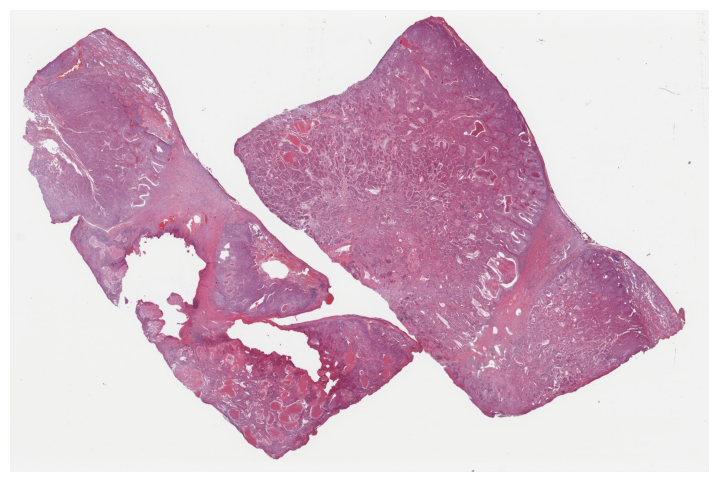

In [123]:
slide = open_slide(svs_path)
image_low = slide.read_region((0,0), len(slide.level_dimensions)-1, slide.level_dimensions[-1])
image_low = np.array(image_low)[:,:,:3]
plt.axis('off')  # Turn off the x and y axis

plt.imshow(image_low), image_low.shape

In [124]:
factor = 8
bags_path = test_dataset.bags_path
dataset_dict = test_dataset.dataset_dict

key = bags_path.index(svs_path.split('/')[-1][:-4])

colors = [np.array([255,0,0]), np.array([0,255,0]), np.array([0,0,255])]

temp_attention_feature = (test_attention_test_bag_feature[key].cpu().numpy()).copy()
temp_attention_patch = (test_attention_test_bag_patch[key].cpu().numpy()).copy()

colored_tiles = np.matmul(temp_attention_patch[:][:, None], colors[0][None, :])
colored_tiles = exposure.rescale_intensity(colored_tiles, out_range=(0, 1))

print(bags_path[key], test_labels_list[key])

patch_list = np.array(all_list[dataset_dict[bags_path[key]][0]:dataset_dict[bags_path[key]][1]])

pos_arr = []

for i in patch_list:
    level, col, row = i.split('/')[-1].split('.')[0].split('_')
    row = int(row)
    col = int(col)
    pos_arr.append([int(row)-1, int(col)-1])
    

pos_arr = np.array(pos_arr)

heatmap = np.zeros((np.amax(pos_arr, 0)[0]+1, np.amax(pos_arr, 0)[1]+1, 3))

for k, pos in enumerate(pos_arr):
    heatmap[pos[0], pos[1]] = colored_tiles[k]
    
heatmap_original = heatmap.copy()
image_low_resize = transform.resize(image_low, (heatmap.shape[0]*factor, heatmap.shape[1]*factor), order=0)
heatmap = transform.resize(heatmap, (heatmap.shape[0]*factor, heatmap.shape[1]*factor), order=0)

top_attended_patch_list = patch_list[np.argsort((test_attention_test_bag_patch[key].cpu().numpy()).copy(), 0)[::-1][:top_k]]

top_attended_patch_index = np.argsort((test_attention_test_bag_patch[key].cpu().numpy()).copy(), 0)[::-1][:top_k]

TCGA-53-A4EZ-01Z-00-DX1.5D155F0B-A677-4589-AF00-A4C451F5B6B6 0


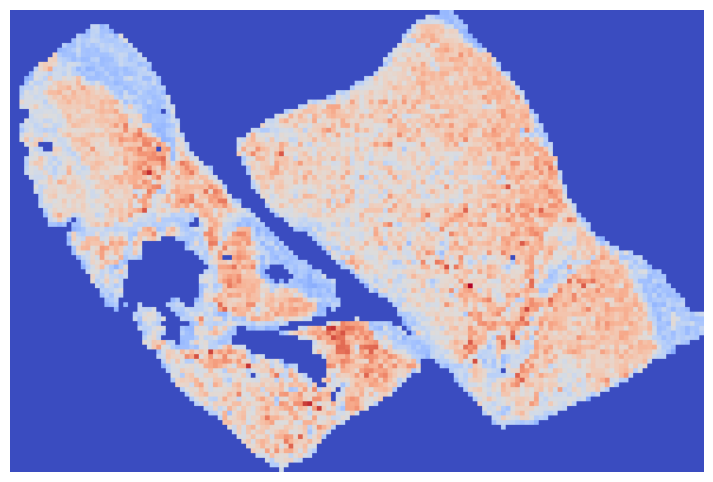

In [125]:
cmap=plt.get_cmap('coolwarm')
mask = (heatmap[:,:,0].copy())

mask[mask<0.1] = 0

color_block = (cmap(mask)*255)[:,:,:3].astype(np.uint8)
plt.rcParams["figure.figsize"] = (20,6)
plt.imshow(color_block)
plt.axis('off')  # Turn off the x and y axis

color_block=np.where(color_block == color_block[0,0], color_block//5, color_block)

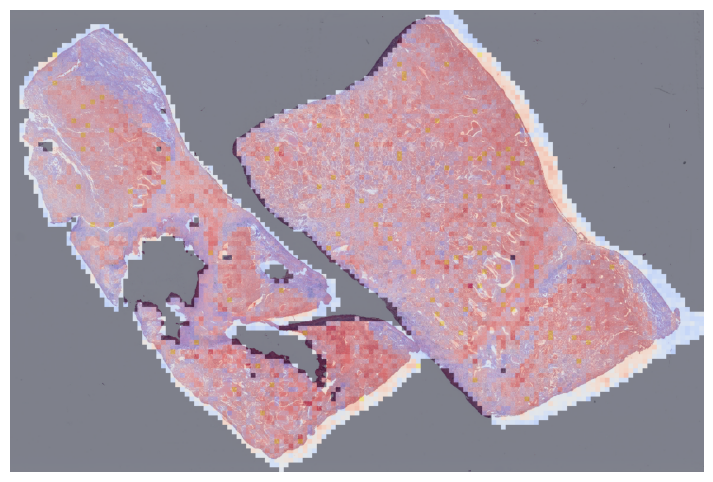

In [126]:
alpha = 0.5
region_hm = cv2.addWeighted(color_block, alpha, image_low_resize.copy(), 1-alpha, 0, image_low_resize.copy())

plt.rcParams["figure.figsize"] = (20,6)
plt.axis('off')  # Turn off the x and y axis

plt.imshow(region_hm)


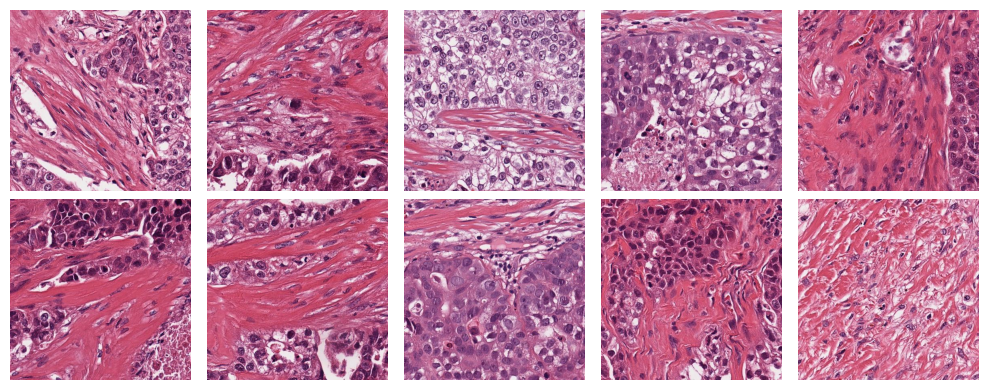

In [128]:

fig, axs = plt.subplots(2, 5, figsize=(10, 4))

for i, ax in enumerate(axs.ravel()):
    img = plt.imread(top_attended_patch_list[i])

    ax.imshow(img)
    ax.set_xticks([])  # Hide x-axis ticks
    ax.set_yticks([])  # Hide y-axis ticks
    ax.spines['top'].set_visible(False)  # Hide top border
    ax.spines['right'].set_visible(False)  # Hide right border
    ax.spines['bottom'].set_visible(False)  # Hide bottom border
    ax.spines['left'].set_visible(False)  # Hide left border
        
plt.tight_layout()

plt.show()

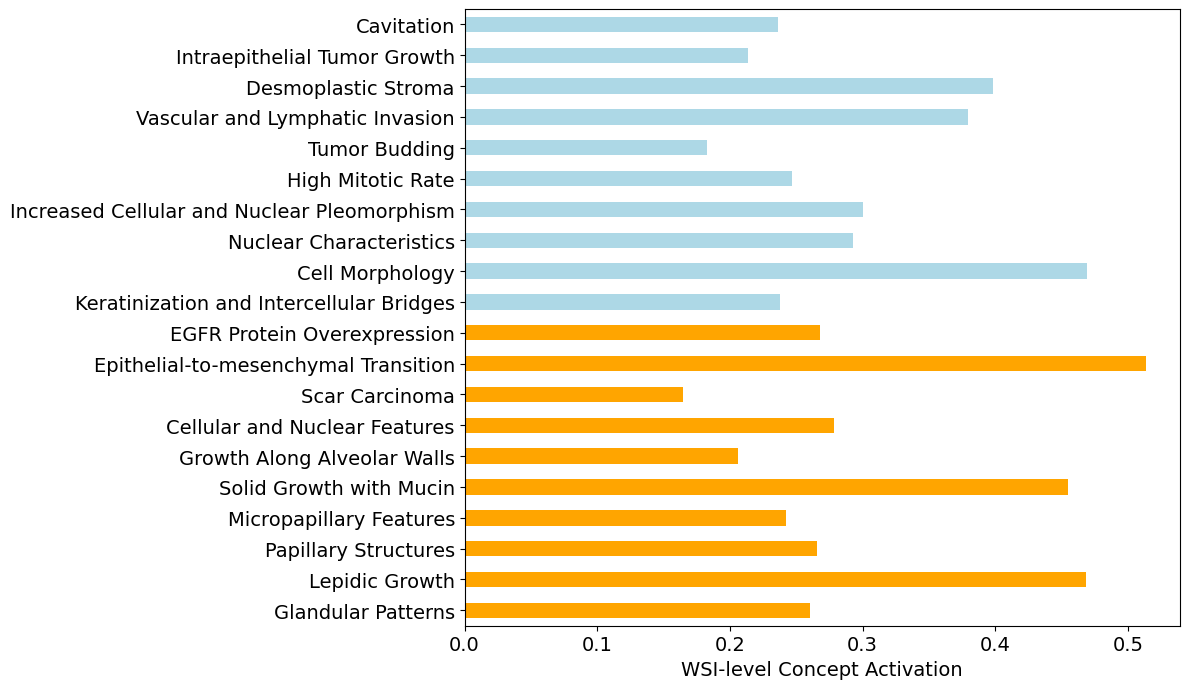

In [127]:
import matplotlib.pyplot as plt

feature_list = (test_dataset.features_array[dataset_dict[bags_path[key]][0]:dataset_dict[bags_path[key]][1]].copy())[top_attended_patch_index]

feature_space = pd.DataFrame(feature_list.copy(), columns = test_dataset.features_prompts)

top_features_index_luad = np.argsort(temp_attention_feature[:number_of_feat_per_class])[::-1]
top_features_index_lusc = np.argsort(temp_attention_feature[number_of_feat_per_class:])[::-1] + number_of_feat_per_class

top_features_index = np.argsort(temp_attention_feature[:])[::-1]

s = (feature_space * temp_attention_feature.reshape((1, -1))).mean()
# Process the index: use only text before the first semicolon
s.index = s.index.to_series().apply(lambda x: x.split(';')[0])

# Prepare the color list: first 10 orange, last 10 lightblue

# Plot the horizontal bar chart
plt.figure(figsize=(12, 7))
ax = s.plot(kind='barh', color=['orange']*10 + ['lightblue']*10)
plt.xlabel('WSI-level Concept Activation', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()
